# Aashia Mehta
# CS 7641: Machine Learning
# Project 1: Supervised Learning

In [580]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt
import time

## Phishing Websites

In [569]:
# https://archive.ics.uci.edu/ml/datasets/phishing+websites
phishing_dataset = pd.read_csv('phishing_websites.csv') 

# https://note.nkmk.me/en/python-pandas-len-shape-size/
phishing_dataset.drop(columns=phishing_dataset.columns[0], 
        axis=1, 
        inplace=True)
print("# of Rows: ", len(phishing_dataset))
print("# of Columns: ", len(phishing_dataset.columns))

num_unique_rows = phishing_dataset.drop_duplicates().shape[0]
print("# of Unique Rows: ", num_unique_rows)
print("% of Unique Rows: ", num_unique_rows / len(phishing_dataset))

duplicate_samples = phishing_dataset[phishing_dataset.duplicated()]
print("# of Duplicate Samples: ", len(duplicate_samples))
duplicate_samples_classes = duplicate_samples.iloc[: , -1]
print("Duplicate Samples Classes Counts: ", duplicate_samples_classes.value_counts())

# https://stackoverflow.com/questions/32589829/how-to-get-value-counts-for-multiple-columns-at-once-in-pandas-dataframe
print("\nCounts Per Feature Column: \n", (phishing_dataset.apply(pd.Series.value_counts) / 11055)*100)

# https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.shape.html
phishing_X = phishing_dataset.iloc[:,:-1]
phishing_Y = phishing_dataset.iloc[: , -1]
print("X Shape: ", phishing_X.shape)
print("Y Shape: ", phishing_Y.shape)
print("Classes Counts: ", phishing_Y.value_counts())

# https://stackoverflow.com/questions/63986466/how-can-i-check-the-sparsity-of-a-pandas-dataframe
sparsity = (phishing_X.to_numpy() == 0).mean()
print("Sparsity: ", sparsity)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# 30-70 split
phishing_X_train, phishing_X_test, phishing_Y_train, phishing_Y_test = train_test_split(phishing_X, phishing_Y, test_size=0.30, random_state=5)
print("X Train Shape: ", phishing_X_train.shape)
print("X Test Shape: ", phishing_X_test.shape)
print("Y Train Shape: ", phishing_Y_train.shape)
print("Y Test Shape: ", phishing_Y_test.shape)

# phishing_fit_times = []
# phishing_predict_times = []
phishing_dataset.head()

# of Rows:  11055
# of Columns:  31
# of Unique Rows:  5849
% of Unique Rows:  0.5290818634102216
# of Duplicate Samples:  5206
Duplicate Samples Classes Counts:   1    3327
-1    1879
Name: Result, dtype: int64

Counts Per Feature Column: 
     having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
-1          34.310267   81.049299           13.061963         14.970602   
 0                NaN    1.221167                 NaN               NaN   
 1          65.689733   17.729534           86.938037         85.029398   

    double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  \
-1                 12.926278      86.748078          30.420624   
 0                       NaN            NaN          32.763455   
 1                 87.073722      13.251922          36.815920   

    SSLfinal_State  Domain_registeration_length    Favicon  ...  popUpWidnow  \
-1       32.175486                    66.838535  18.570782  ...     19.33062   
 0       10.556309              

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [588]:
# https://chrisalbon.com/code/machine_learning/model_evaluation/plot_the_validation_curve/
def create_validation_curve(classifier, X, Y, param_name, param_range, title, x_label):
    # Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(classifier, 
                                                 X, 
                                                 Y, 
                                                 param_name=param_name, 
                                                 param_range=param_range,
                                                 cv=3, 
                                                 scoring="accuracy", 
                                                 n_jobs=1)


    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    if x_label == "weights":
        train_error = [np.std(train_scores[0]), np.std(train_scores[1])]
        test_error = [np.std(test_scores[0]), np.std(test_scores[1])]
        plt.bar(param_range, train_mean, yerr=train_error, label="Training score", color="lightcoral")
        plt.bar(param_range, test_mean, yerr=test_error, label="Cross-validation score", color="gold")
        plt.title("Validation Bar Chart With " + title)
    elif x_label == "kernel":
        train_error = [np.std(train_scores[0]), np.std(train_scores[1]), np.std(train_scores[2]), np.std(train_scores[3])]
        test_error = [np.std(test_scores[0]), np.std(test_scores[1]), np.std(train_scores[2]), np.std(train_scores[3])]
        plt.bar(param_range, train_mean, yerr=train_error, label="Training score", color="lightcoral")
        plt.bar(param_range, test_mean, yerr=test_error, label="Cross-validation score", color="gold")
        plt.title("Validation Bar Chart With " + title)
    else:
        # Plot mean accuracy scores for training and test sets
        plt.plot(param_range, train_mean, label="Training score", color="lightcoral")
        plt.plot(param_range, test_mean, label="Cross-validation score", color="gold")

        # Plot accurancy bands for training and test sets
        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="mistyrose")
        plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="lemonchiffon")
        plt.title("Validation Curve With " + title)

    # Create plot
    plt.xlabel(x_label)
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.show()
    
# https://chrisalbon.com/code/machine_learning/model_evaluation/plot_the_learning_curve/
def create_learning_curve(classifier, X, Y, title):
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(classifier, 
                                                            X, 
                                                            Y,
                                                            cv=3,
                                                            scoring='accuracy',
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 5))

    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="lightcoral",  label="Training score")
    plt.plot(train_sizes, test_mean, color="gold", label="Cross-validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="mistyrose")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="lemonchiffon")

    # Create plot
    plt.title("Learning Curve With " + title)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

### Decision Tree

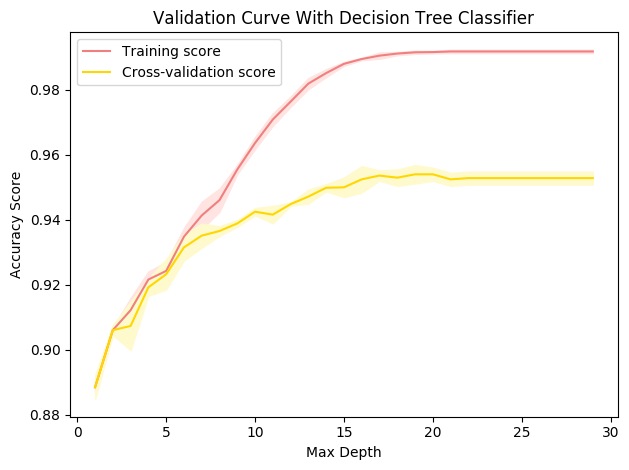

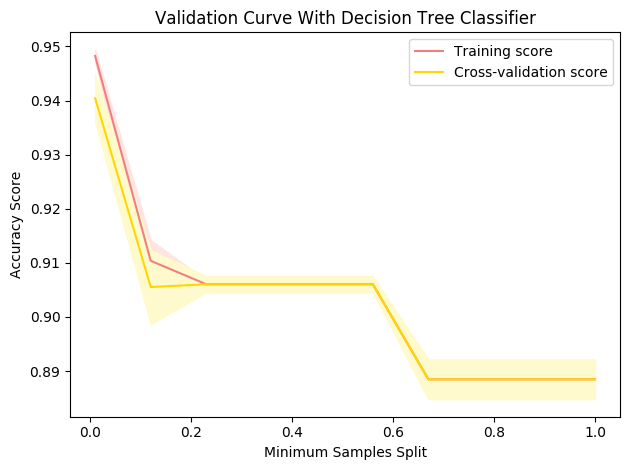

In [547]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
phishing_dt = DecisionTreeClassifier(random_state=5)

create_validation_curve(phishing_dt, phishing_X_train, phishing_Y_train, "max_depth", np.arange(1, 30), "Decision Tree Classifier", "Max Depth")
create_validation_curve(phishing_dt, phishing_X_train, phishing_Y_train, "min_samples_split", np.linspace(0.01, 1.0, 10), "Decision Tree Classifier", "Minimum Samples Split")

Accuracy w/o Tuning:  0.9656315948145915
Best Params:  {'max_depth': 19} DecisionTreeClassifier(max_depth=19, random_state=5)
Accuracy Score w/ Tuning:  0.964124208622249


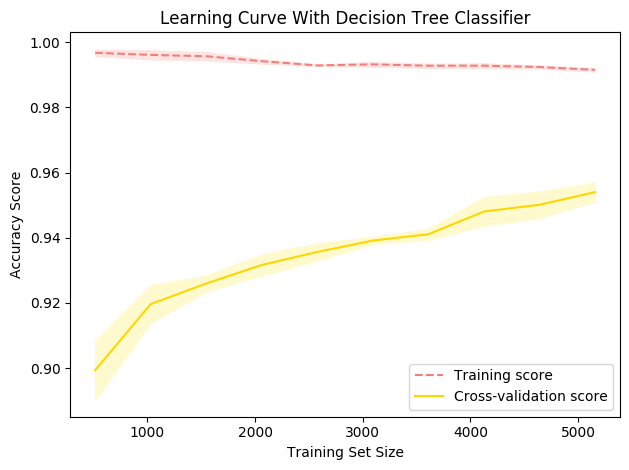

In [543]:
phishing_dt.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = phishing_dt.predict(phishing_X_test)
phishing_dt_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/o Tuning: ", phishing_dt_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"max_depth": np.arange(1, 30)}
phishing_dt_tuned = GridSearchCV(phishing_dt, param_grid, scoring='accuracy', cv=3)
phishing_dt_tuned.fit(phishing_X_train, phishing_Y_train)
best_params = phishing_dt_tuned.best_params_
best_estimator = phishing_dt_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_phishing_dt = best_estimator
final_phishing_dt.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = final_phishing_dt.predict(phishing_X_test)
final_phishing_dt_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy Score w/ Tuning: ", final_phishing_dt_accuracy)

create_learning_curve(final_phishing_dt, phishing_X_train, phishing_Y_train, "Decision Tree Classifier")

In [461]:
fit_time_start = time.time()
final_phishing_dt.fit(phishing_X_train, phishing_Y_train)
fit_time_end = time.time()
phishing_fit_time = (fit_time_end - fit_time_start) * 100
phishing_fit_times.append(phishing_fit_time)

predict_time_start = time.time()
phishing_Y_pred = final_phishing_dt.predict(phishing_X_test)
predict_time_end = time.time()
phishing_predict_time = (predict_time_end - predict_time_start) * 100
phishing_predict_times.append(phishing_predict_time)

print(phishing_fit_times, phishing_predict_times)

[2.1277904510498047, 296.66082859039307, 93.11742782592773, 0.5748987197875977, 4412.651324272156, 15.647411346435547, 2.309131622314453, 2.1530866622924805, 1.7663002014160156, 2.500009536743164] [0.23849010467529297, 13.997697830200195, 54.77550029754639, 104.65748310089111, 5.794000625610352, 0.7086038589477539, 0.24487972259521484, 0.2033233642578125, 0.20532608032226562, 0.3342866897583008]
Accuracy w/ Tuning:  0.964124208622249


In [460]:
# plt.figure(figsize=(50,50))
# features = list(phishing_X_train.columns)
# tree.plot_tree(final_phishing_dt, fontsize=10, feature_names=features, class_names=["1", "-1"])
# plt.savefig("phishing_tree.png")

/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


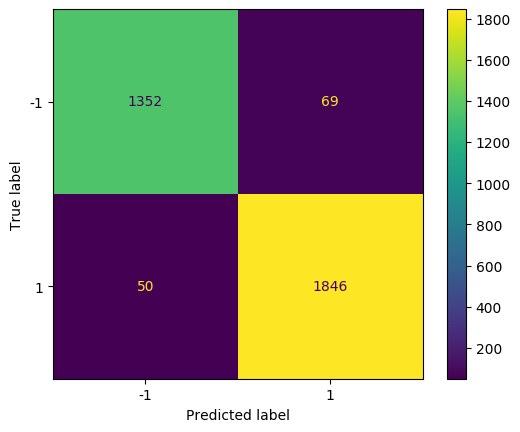

In [397]:
cm = plot_confusion_matrix(final_phishing_dt, phishing_X_test, phishing_Y_test)
plt.show()

### Boosting

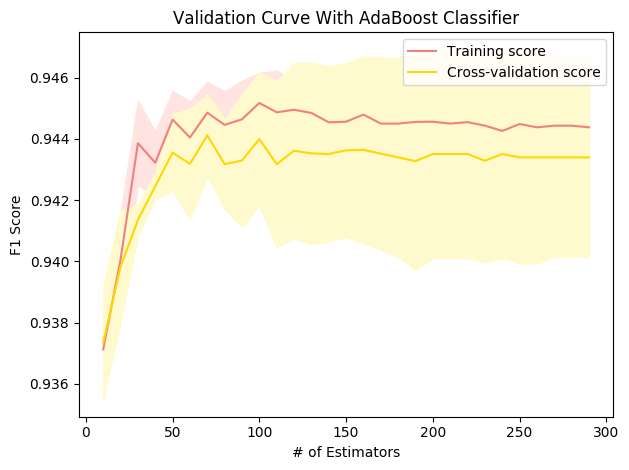

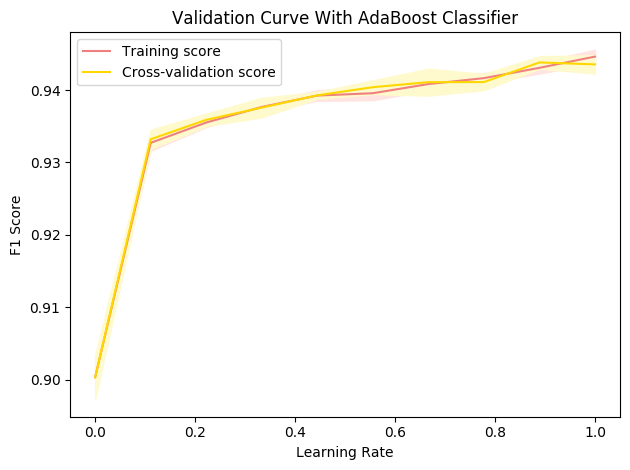

In [493]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
phishing_boosting_dt = DecisionTreeClassifier(max_depth=1, random_state=5)
phishing_boosting = AdaBoostClassifier(phishing_boosting_dt, random_state=5)

create_validation_curve(phishing_boosting, phishing_X_train, phishing_Y_train, "n_estimators", np.arange(10, 300, 10), "AdaBoost Classifier", "# of Estimators")
create_validation_curve(phishing_boosting, phishing_X_train, phishing_Y_train, "learning_rate", np.linspace(0.001, 1.0, 10), "AdaBoost Classifier", "Learning Rate")

Accuracy w/o Tuning:  0.9394030750678324


/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Best Params:  {'base_estimator__max_depth': 6, 'learning_rate': 0.445, 'n_estimators': 275} AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                         random_state=5),
                   learning_rate=0.445, n_estimators=275, random_state=5)
Accuracy w/ Tuning:  0.9716611395839614


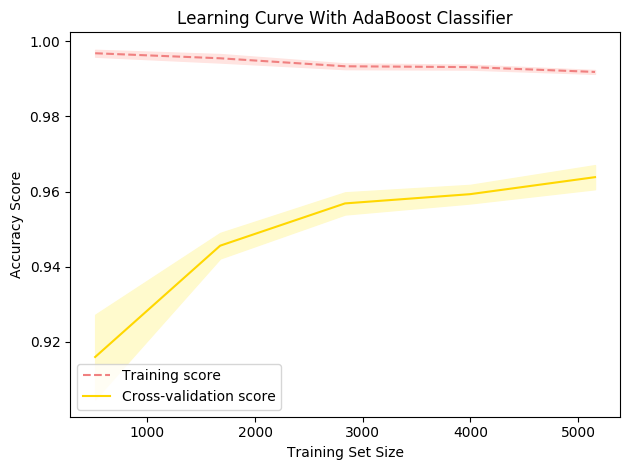

In [536]:
phishing_boosting.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = phishing_boosting.predict(phishing_X_test)
phishing_boosting_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/o Tuning: ", phishing_boosting_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"n_estimators": [275], "learning_rate": [0.445], 'base_estimator__max_depth':np.arange(1, 30)}
phishing_boosting_tuned = GridSearchCV(phishing_boosting, param_grid, scoring='accuracy', cv=3)
phishing_boosting_tuned.fit(phishing_X_train, phishing_Y_train)
best_params = phishing_boosting_tuned.best_params_
best_estimator = phishing_boosting_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_phishing_boosting = best_estimator
final_phishing_boosting.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = final_phishing_boosting.predict(phishing_X_test)
final_phishing_boosting_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_boosting_accuracy)

create_learning_curve(final_phishing_boosting, phishing_X_train, phishing_Y_train, "AdaBoost Classifier")

In [367]:
fit_time_start = time.time()
final_phishing_boosting.fit(phishing_X_train, phishing_Y_train)
fit_time_end = time.time()
phishing_fit_time = (fit_time_end - fit_time_start) * 100
phishing_fit_times.append(phishing_fit_time)

predict_time_start = time.time()
phishing_Y_pred = final_phishing_boosting.predict(phishing_X_test)
predict_time_end = time.time()
phishing_predict_time = (predict_time_end - predict_time_start) * 100
phishing_predict_times.append(phishing_predict_time)

print(phishing_fit_times, phishing_predict_times)

final_phishing_boosting_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_boosting_accuracy)

[2.1277904510498047, 296.66082859039307] [0.23849010467529297, 13.997697830200195]
Accuracy w/ Tuning:  0.9716611395839614


/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


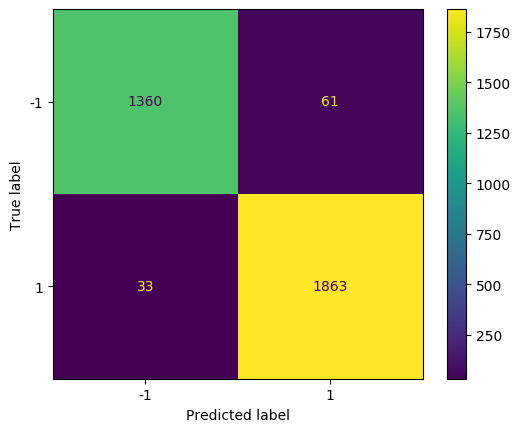

In [408]:
cm = plot_confusion_matrix(final_phishing_boosting, phishing_X_test, phishing_Y_test)
plt.show()

### SVM

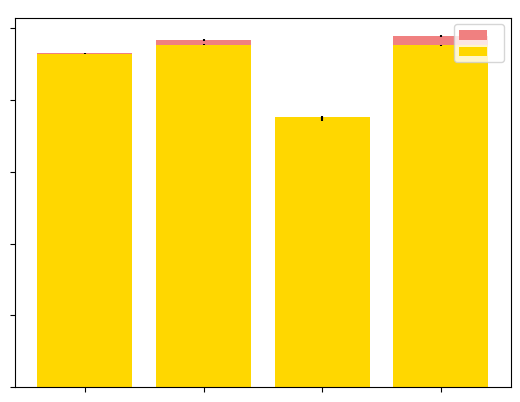

In [591]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
phishing_svm = SVC(random_state=5, gamma = 0.1)

# create_validation_curve(phishing_svm, phishing_X_train, phishing_Y_train, "C", [0.1, 1, 10, 30, 50, 75, 100], "SVM Classifier", "C")
# create_validation_curve(phishing_svm, phishing_X_train, phishing_Y_train, "gamma", [0.00001, 0.0001, 0.001, 0.01, 0.1], "SVM Classifier", "gamma")
create_validation_curve(phishing_svm, phishing_X_train, phishing_Y_train, "kernel", ['linear', 'rbf', 'sigmoid', 'poly'], "SVM Classifier", "kernel")

Accuracy w/o Tuning:  0.9559843231835996
Best Params:  {'C': 30, 'gamma': 0.1} SVC(C=30, gamma=0.1, random_state=5)
Accuracy w/ Tuning:  0.9638227313837805


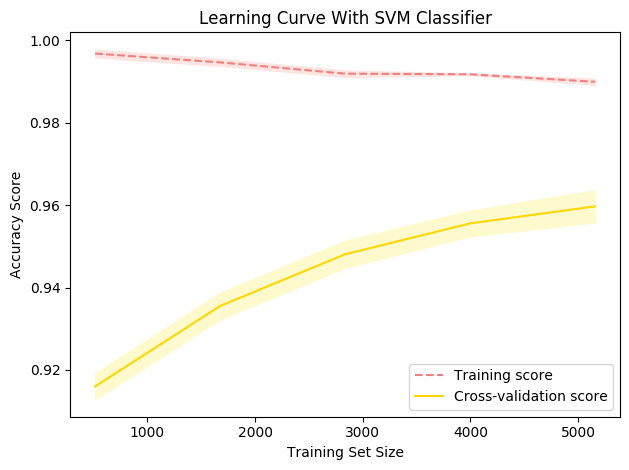

In [280]:
phishing_svm.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = phishing_svm.predict(phishing_X_test)
phishing_svm_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/o Tuning: ", phishing_svm_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"C": [0.1, 1, 10, 30, 50, 75, 100], "gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1]}
phishing_svm_tuned = GridSearchCV(phishing_svm, param_grid, scoring='accuracy', cv=3)
phishing_svm_tuned.fit(phishing_X_train, phishing_Y_train)
best_params = phishing_svm_tuned.best_params_
best_estimator = phishing_svm_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_phishing_svm = best_estimator
final_phishing_svm.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = final_phishing_svm.predict(phishing_X_test)
final_phishing_svm_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_svm_accuracy)

create_learning_curve(final_phishing_svm, phishing_X_train, phishing_Y_train, "SVM Classifier")

In [368]:
fit_time_start = time.time()
final_phishing_svm.fit(phishing_X_train, phishing_Y_train)
fit_time_end = time.time()
phishing_fit_time = (fit_time_end - fit_time_start) * 100
phishing_fit_times.append(phishing_fit_time)

predict_time_start = time.time()
phishing_Y_pred = final_phishing_svm.predict(phishing_X_test)
predict_time_end = time.time()
phishing_predict_time = (predict_time_end - predict_time_start) * 100
phishing_predict_times.append(phishing_predict_time)

print(phishing_fit_times, phishing_predict_times)

final_phishing_svm_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_svm_accuracy)

[2.1277904510498047, 296.66082859039307, 93.11742782592773] [0.23849010467529297, 13.997697830200195, 54.77550029754639]
Accuracy w/ Tuning:  0.9638227313837805


### KNN

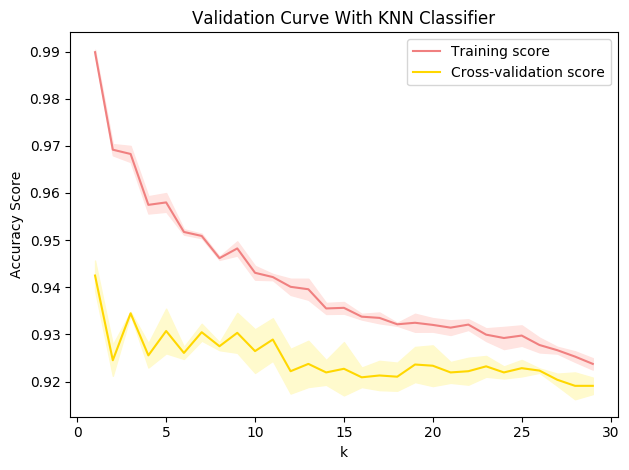

In [266]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
phishing_knn = KNeighborsClassifier()

create_validation_curve(phishing_knn, phishing_X_train, phishing_Y_train, "n_neighbors", list(range(1, 30)), "KNN Classifier", "k")
# create_validation_curve(phishing_knn, phishing_X_train, phishing_Y_train, "weights", ['uniform', 'distance'], "KNN Classifier", "weights")
# create_validation_curve(phishing_knn, phishing_X_train, phishing_Y_train, "metric", ['minkowski', 'euclidean', 'manhattan'], "KNN Classifier", "metric")

Best Params:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'} KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')
Accuracy w/ Tuning:  0.963521254145312


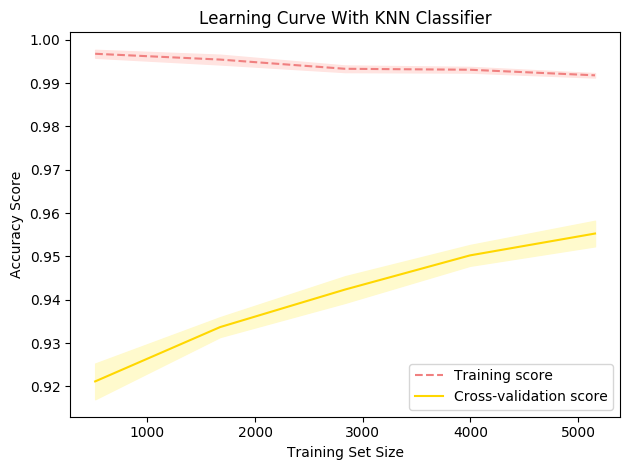

In [252]:
phishing_knn.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = phishing_knn.predict(phishing_X_test)
phishing_knn_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/o Tuning: ", phishing_knn_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"n_neighbors": list(range(1, 50)), "weights": ['uniform', 'distance'], "metric": ['minkowski', 'euclidean', 'manhattan']}
phishing_knn_tuned = GridSearchCV(phishing_knn, param_grid, scoring='accuracy', cv=3)
phishing_knn_tuned.fit(phishing_X_train, phishing_Y_train)
best_params = phishing_knn_tuned.best_params_
best_estimator = phishing_knn_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_phishing_knn = best_estimator
final_phishing_knn.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = final_phishing_knn.predict(phishing_X_test)
final_phishing_knn_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_knn_accuracy)

create_learning_curve(final_phishing_knn, phishing_X_train, phishing_Y_train, "KNN Classifier")

In [369]:
fit_time_start = time.time()
final_phishing_knn.fit(phishing_X_train, phishing_Y_train)
fit_time_end = time.time()
phishing_fit_time = (fit_time_end - fit_time_start) * 100
phishing_fit_times.append(phishing_fit_time)

predict_time_start = time.time()
phishing_Y_pred = final_phishing_knn.predict(phishing_X_test)
predict_time_end = time.time()
phishing_predict_time = (predict_time_end - predict_time_start) * 100
phishing_predict_times.append(phishing_predict_time)

print(phishing_fit_times, phishing_predict_times)

final_phishing_knn_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_knn_accuracy)

[2.1277904510498047, 296.66082859039307, 93.11742782592773, 0.5748987197875977] [0.23849010467529297, 13.997697830200195, 54.77550029754639, 104.65748310089111]
Accuracy w/ Tuning:  0.963521254145312


/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


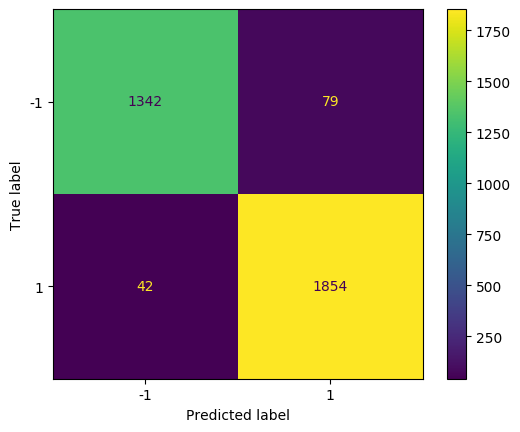

In [396]:
cm = plot_confusion_matrix(final_phishing_knn, phishing_X_test, phishing_Y_test)
plt.show()

### Neural Networks

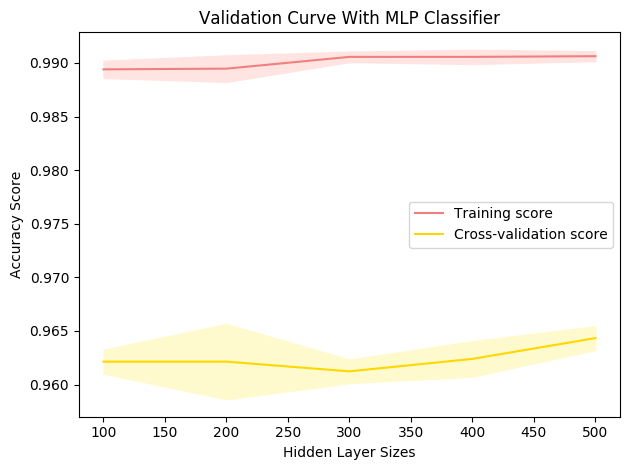

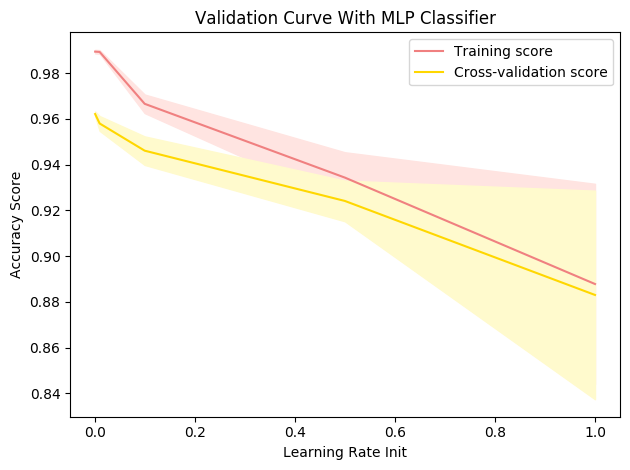

In [316]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
phishing_mlp = MLPClassifier(random_state=5, max_iter=500)

# create_validation_curve(phishing_mlp, phishing_X_train, phishing_Y_train, "activation", ['identity', 'logistic', 'tanh', 'relu'], "MLP Classifier", "Activation")
create_validation_curve(phishing_mlp, phishing_X_train, phishing_Y_train, "hidden_layer_sizes", [100, 200, 300, 400, 500], "MLP Classifier", "Hidden Layer Sizes")
create_validation_curve(phishing_mlp, phishing_X_train, phishing_Y_train, "learning_rate_init", [0.001, 0.01, 0.1, 0.5, 1], "MLP Classifier", "Learning Rate Init")

Accuracy w/o Tuning:  0.967741935483871


/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) r

Best Params:  {'activation': 'tanh', 'hidden_layer_sizes': 500, 'learning_rate_init': 0.001} MLPClassifier(activation='tanh', hidden_layer_sizes=500, max_iter=500,
              random_state=5)
Accuracy w/ Tuning:  0.969550798914682


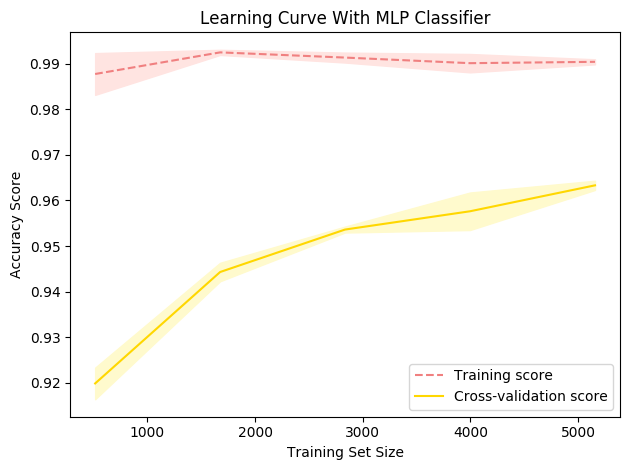

/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [428]:
phishing_mlp.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = phishing_mlp.predict(phishing_X_test)
phishing_mlp_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/o Tuning: ", phishing_mlp_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"hidden_layer_sizes": [500], "learning_rate_init": [0.001], "activation": ["tanh"]}
phishing_mlp_tuned = GridSearchCV(phishing_mlp, param_grid, scoring='accuracy', cv=3)
phishing_mlp_tuned.fit(phishing_X_train, phishing_Y_train)
best_params = phishing_mlp_tuned.best_params_
best_estimator = phishing_mlp_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_phishing_mlp = best_estimator
final_phishing_mlp.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = final_phishing_mlp.predict(phishing_X_test)
final_phishing_mlp_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_mlp_accuracy)

create_learning_curve(final_phishing_mlp, phishing_X_train, phishing_Y_train, "MLP Classifier")

In [370]:
fit_time_start = time.time()
final_phishing_mlp.fit(phishing_X_train, phishing_Y_train)
fit_time_end = time.time()
phishing_fit_time = (fit_time_end - fit_time_start) * 100
phishing_fit_times.append(phishing_fit_time)

predict_time_start = time.time()
phishing_Y_pred = final_phishing_mlp.predict(phishing_X_test)
predict_time_end = time.time()
phishing_predict_time = (predict_time_end - predict_time_start) * 100
phishing_predict_times.append(phishing_predict_time)

print(phishing_fit_times, phishing_predict_times)

final_phishing_mlp_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_mlp_accuracy)

[2.1277904510498047, 296.66082859039307, 93.11742782592773, 0.5748987197875977, 4412.651324272156] [0.23849010467529297, 13.997697830200195, 54.77550029754639, 104.65748310089111, 5.794000625610352]
Accuracy w/ Tuning:  0.969550798914682


/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training Score 0.0001 0.9680796071336263
Training Score 0.001 0.9895321788575859
Training Score 0.01 0.9900491082967176
Training Score 0.1 0.9645903334194882


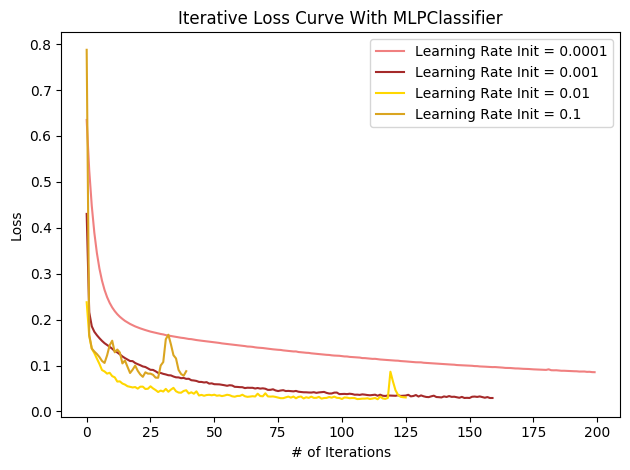

In [431]:
# https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html?highlight=loss+curve
phishing_mlp_1 = MLPClassifier(hidden_layer_sizes=500, learning_rate_init = 0.0001, 
                           random_state=5)
phishing_mlp_1.fit(phishing_X_train, phishing_Y_train)
plt.plot(phishing_mlp_1.loss_curve_, color="lightcoral", label="Learning Rate Init = 0.0001")
print("Training Score 0.0001", phishing_mlp_1.score(phishing_X_train, phishing_Y_train))

phishing_mlp_2 = MLPClassifier(hidden_layer_sizes=400, learning_rate_init = 0.001, 
                           random_state=5)
phishing_mlp_2.fit(phishing_X_train, phishing_Y_train)
plt.plot(phishing_mlp_2.loss_curve_, color="brown", label="Learning Rate Init = 0.001")
print("Training Score 0.001", phishing_mlp_2.score(phishing_X_train, phishing_Y_train))

phishing_mlp_3 = MLPClassifier(hidden_layer_sizes=400, learning_rate_init = 0.01, 
                           random_state=5)
phishing_mlp_3.fit(phishing_X_train, phishing_Y_train)
plt.plot(phishing_mlp_3.loss_curve_, color="gold", label="Learning Rate Init = 0.01")
print("Training Score 0.01", phishing_mlp_3.score(phishing_X_train, phishing_Y_train))

phishing_mlp_4 = MLPClassifier(hidden_layer_sizes=400, learning_rate_init = 0.1, 
                           random_state=5)
phishing_mlp_4.fit(phishing_X_train, phishing_Y_train)
plt.plot(phishing_mlp_4.loss_curve_, color="goldenrod", label="Learning Rate Init = 0.1")
print("Training Score 0.1", phishing_mlp_4.score(phishing_X_train, phishing_Y_train))


plt.title("Iterative Loss Curve With MLPClassifier")
plt.xlabel("# of Iterations")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

[2.1277904510498047, 296.66082859039307, 93.11742782592773, 0.5748987197875977, 4412.651324272156]
[0.0213, 2.9666, 0.9312, 0.0057, 44.1265]


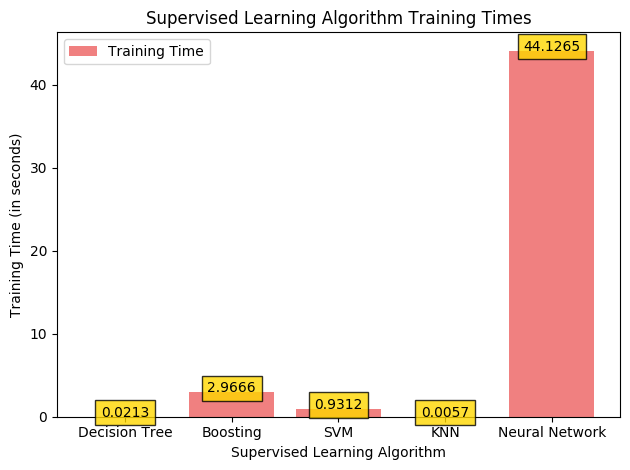

In [381]:
# https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html?highlight=loss+curve

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 Bbox = dict(facecolor = 'gold', alpha =.8))

classifiers = ["Decision Tree", "Boosting", "SVM", "KNN", "Neural Network"]
print(phishing_fit_times)
phishing_fit_times_s = [round(i / 100, 4) for i in phishing_fit_times]
print(phishing_fit_times_s)
plt.bar(classifiers, phishing_fit_times_s, color="lightcoral", label="Training Time")
addlabels(classifiers, phishing_fit_times_s)
plt.title("Supervised Learning Algorithm Training Times")
plt.xlabel("Supervised Learning Algorithm")
plt.ylabel("Training Time (in seconds)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

[0.23849010467529297, 13.997697830200195, 54.77550029754639, 104.65748310089111, 5.794000625610352]
[0.0024, 0.14, 0.5478, 1.0466, 0.0579]


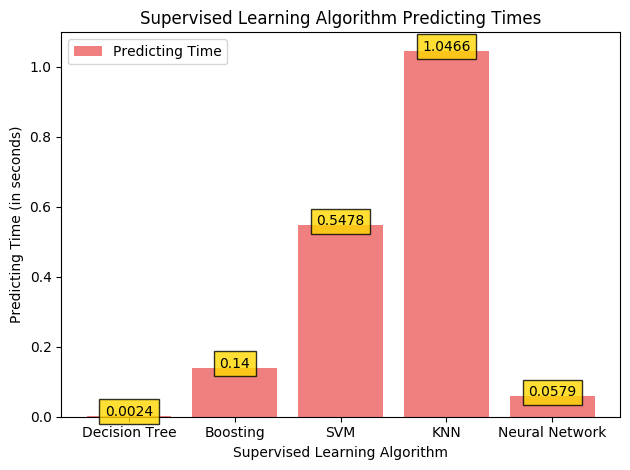

In [380]:
print(phishing_predict_times)
phishing_predict_times_s = [round(i / 100, 4) for i in phishing_predict_times]
print(phishing_predict_times_s)
plt.bar(classifiers, phishing_predict_times_s, color="lightcoral", label="Predicting Time")
addlabels(classifiers, phishing_predict_times_s)
plt.title("Supervised Learning Algorithm Predicting Times")
plt.xlabel("Supervised Learning Algorithm")
plt.ylabel("Predicting Time (in seconds)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

## Wine Quality

In [470]:
# https://archive.ics.uci.edu/ml/datasets/wine+quality
wine_dataset = pd.read_csv('wine_quality.csv')  
print("# of Rows: ", len(wine_dataset))
print("# of Columns: ", len(wine_dataset.columns))

# https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.shape.html
wine_X = wine_dataset.iloc[:,:-1]
wine_Y = wine_dataset.iloc[: , -1]
print("X Shape: ", wine_X.shape)
print("Y Shape: ", wine_Y.shape)
num_unique_rows = wine_dataset.drop_duplicates().shape[0]
print("# of Unique Rows: ", num_unique_rows)
print("% of Unique Rows: ", num_unique_rows / len(wine_dataset))
duplicate_samples = wine_dataset[wine_dataset.duplicated()]
print("# of Duplicate Samples: ", len(duplicate_samples))
duplicate_samples_classes = duplicate_samples.iloc[: , -1]
print("Duplicate Samples Classes Counts: ", duplicate_samples_classes.value_counts())

# https://stackoverflow.com/questions/63986466/how-can-i-check-the-sparsity-of-a-pandas-dataframe
sparsity = (wine_X.to_numpy() == 0).mean()
print("Sparsity: ", sparsity)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# 30-70 split
wine_X_train, wine_X_test, wine_Y_train, wine_Y_test = train_test_split(wine_X, wine_Y, test_size=0.30, random_state=5)
print("X Train Shape: ", wine_X_train.shape)
print("X Test Shape: ", wine_X_test.shape)
print("Y Train Shape: ", wine_Y_train.shape)
print("Y Test Shape: ", wine_Y_test.shape)

print(wine_Y.value_counts())

wine_dataset.head()
wine_fit_times = []
wine_predict_times = []

# of Rows:  1599
# of Columns:  12
X Shape:  (1599, 11)
Y Shape:  (1599,)
# of Unique Rows:  1359
% of Unique Rows:  0.849906191369606
# of Duplicate Samples:  240
Duplicate Samples Classes Counts:  5    104
6    103
7     32
8      1
Name: quality, dtype: int64
Sparsity:  0.0075046904315197
X Train Shape:  (1119, 11)
X Test Shape:  (480, 11)
Y Train Shape:  (1119,)
Y Test Shape:  (480,)
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


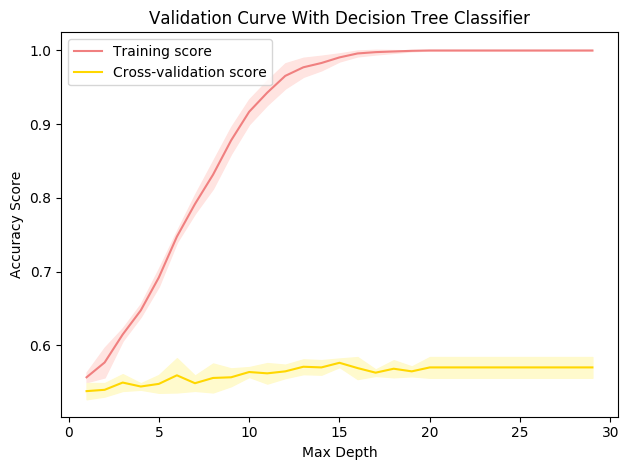

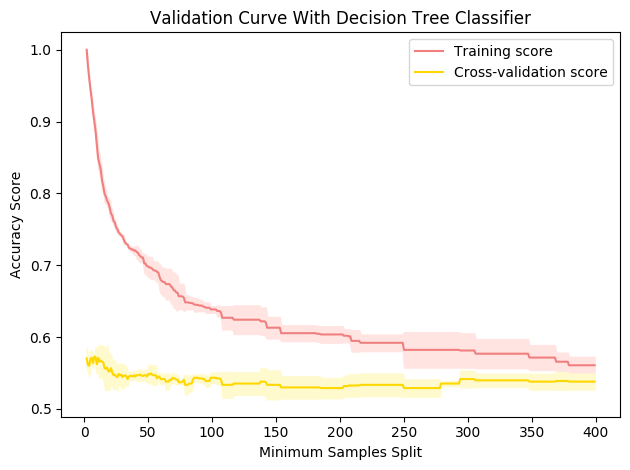

In [130]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
wine_dt = DecisionTreeClassifier(random_state=5)

create_validation_curve(wine_dt, wine_X_train, wine_Y_train, "max_depth", np.arange(1, 30), "Decision Tree Classifier", "Max Depth")
create_validation_curve(wine_dt, wine_X_train, wine_Y_train, "min_samples_split", np.linspace(0.1, 1.0, 10), "Decision Tree Classifier", "Minimum Samples Split")

Accuracy w/o Tuning:  0.6083333333333333
Best Params:  {'max_depth': 15} DecisionTreeClassifier(max_depth=15, random_state=5)
Accuracy w/ Tuning:  0.6125


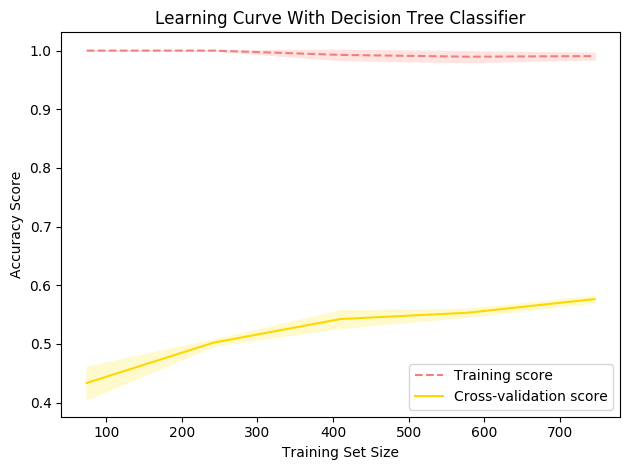

In [523]:
wine_dt.fit(wine_X_train, wine_Y_train)
wine_Y_pred = wine_dt.predict(wine_X_test)
wine_dt_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/o Tuning: ", wine_dt_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"max_depth":np.arange(1, 30)}
wine_dt_tuned = GridSearchCV(wine_dt, param_grid, scoring='accuracy', cv=3)
wine_dt_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_dt_tuned.best_params_
best_estimator = wine_dt_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_dt = best_estimator
final_wine_dt.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_dt.predict(wine_X_test)
final_wine_dt_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/ Tuning: ", final_wine_dt_accuracy)

create_learning_curve(final_wine_dt, wine_X_train, wine_Y_train, "Decision Tree Classifier")

/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


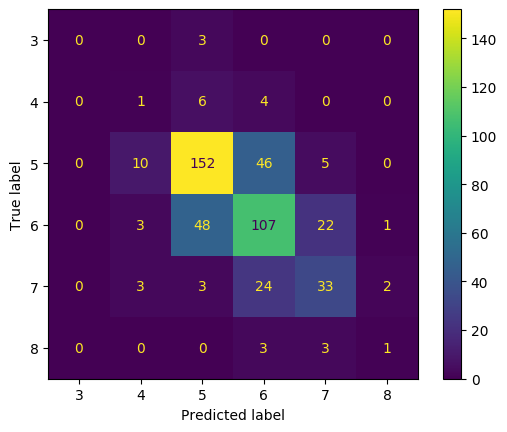

In [517]:
cm = plot_confusion_matrix(final_wine_dt, wine_X_test, wine_Y_test)
plt.show()

Best Params:  {'max_depth': 16} DecisionTreeClassifier(max_depth=16, random_state=5)
F1 Score w/ Tuning:  0.340399507498037


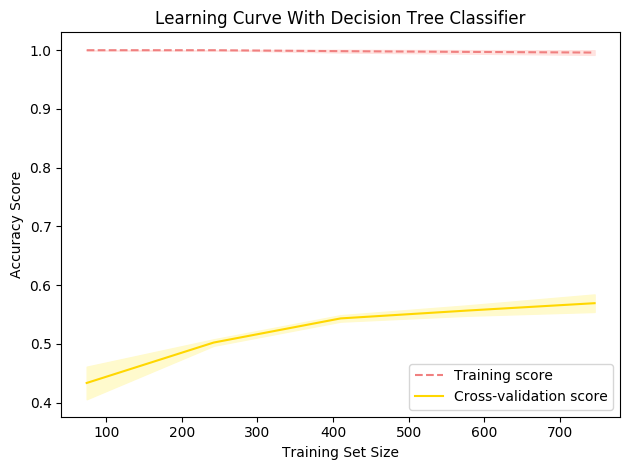

In [518]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"max_depth":np.arange(1, 30)}
wine_dt_tuned = GridSearchCV(wine_dt, param_grid, scoring='f1_macro', cv=3)
wine_dt_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_dt_tuned.best_params_
best_estimator = wine_dt_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_dt = best_estimator
final_wine_dt.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_dt.predict(wine_X_test)
final_wine_dt_f1_score = f1_score(wine_Y_test, wine_Y_pred, average="macro")
print("F1 Score w/ Tuning: ", final_wine_dt_f1_score)

create_learning_curve(final_wine_dt, wine_X_train, wine_Y_train, "Decision Tree Classifier")

/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


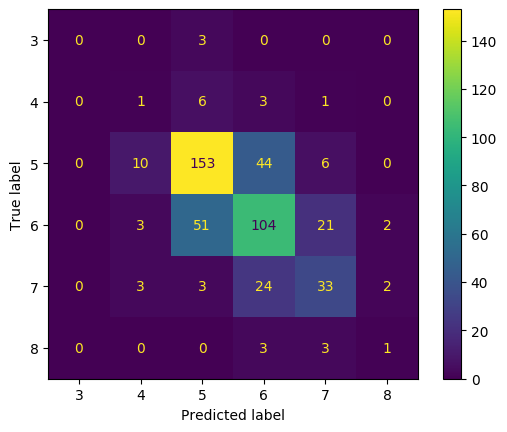

In [519]:
cm = plot_confusion_matrix(final_wine_dt, wine_X_test, wine_Y_test)
plt.show()

In [520]:
fit_time_start = time.time()
final_wine_dt.fit(wine_X_train, wine_Y_train)
fit_time_end = time.time()
wine_fit_time = (fit_time_end - fit_time_start) * 100
wine_fit_times.append(wine_fit_time)

predict_time_start = time.time()
wine_Y_pred = final_wine_dt.predict(wine_X_test)
predict_time_end = time.time()
wine_predict_time = (predict_time_end - predict_time_start) * 100
wine_predict_times.append(wine_predict_time)

print(wine_fit_times, wine_predict_times)

[1.5590906143188477] [0.3098011016845703]


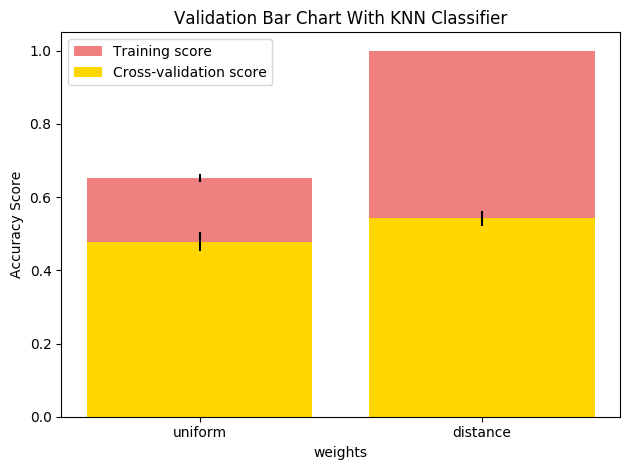

In [259]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
wine_knn = KNeighborsClassifier()

# create_validation_curve(wine_knn, wine_X_train, wine_Y_train, "n_neighbors", list(range(1, 50)), "KNN Classifier", "k")
create_validation_curve(wine_knn, wine_X_train, wine_Y_train, "weights", ['uniform', 'distance'], "KNN Classifier", "weights")
# create_validation_curve(wine_knn, wine_X_train, wine_Y_train, "metric", ['minkowski', 'euclidean', 'manhattan'], "KNN Classifier", "metric")

Accuracy w/o Tuning:  0.49166666666666664
Best Params:  {'metric': 'manhattan', 'n_neighbors': 43, 'weights': 'distance'} KNeighborsClassifier(metric='manhattan', n_neighbors=43, weights='distance')
Accuracy w/ Tuning:  0.6375


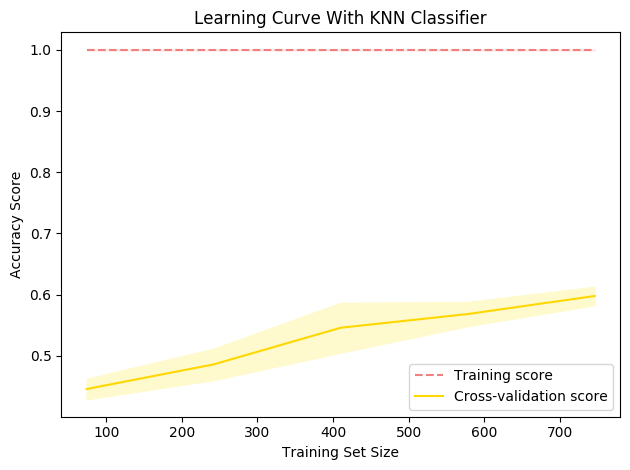

In [522]:
wine_knn.fit(wine_X_train, wine_Y_train)
wine_Y_pred = wine_knn.predict(wine_X_test)
wine_knn_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/o Tuning: ", wine_knn_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"n_neighbors": list(range(1, 50)), "weights": ['uniform', 'distance'], "metric": ['minkowski', 'euclidean', 'manhattan']}
wine_knn_tuned = GridSearchCV(wine_knn, param_grid, scoring='accuracy', cv=3)
wine_knn_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_knn_tuned.best_params_
best_estimator = wine_knn_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_knn = best_estimator
final_wine_knn.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_knn.predict(wine_X_test)
final_wine_knn_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/ Tuning: ", final_wine_knn_accuracy)

create_learning_curve(final_wine_knn, wine_X_train, wine_Y_train, "KNN Classifier")

/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


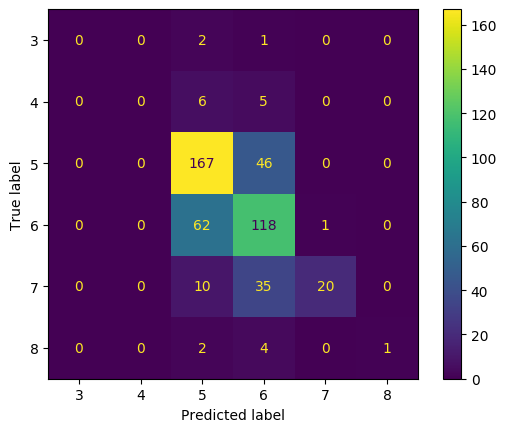

In [525]:
cm = plot_confusion_matrix(final_wine_knn, wine_X_test, wine_Y_test)
plt.show()

In [526]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"n_neighbors": list(range(1, 50)), "weights": ['uniform', 'distance'], "metric": ['minkowski', 'euclidean', 'manhattan']}
wine_knn_tuned = GridSearchCV(wine_knn, param_grid, scoring='f1_macro', cv=3)
wine_knn_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_knn_tuned.best_params_
best_estimator = wine_knn_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_knn = best_estimator
final_wine_knn.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_knn.predict(wine_X_test)
final_wine_knn_f1_score = f1_score(wine_Y_test, wine_Y_pred, average="macro")
print("F1 Score w/ Tuning: ", final_wine_knn_f1_score)

Best Params:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'} KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
F1 Score w/ Tuning:  0.3405488747060799


/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


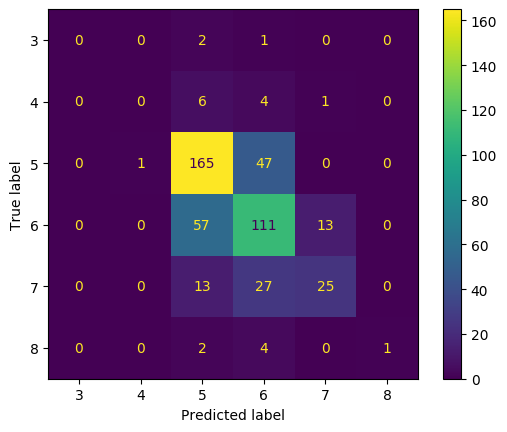

In [527]:
cm = plot_confusion_matrix(final_wine_knn, wine_X_test, wine_Y_test)
plt.show()

In [524]:
fit_time_start = time.time()
final_wine_knn.fit(wine_X_train, wine_Y_train)
fit_time_end = time.time()
wine_fit_time = (fit_time_end - fit_time_start) * 100
wine_fit_times.append(wine_fit_time)

predict_time_start = time.time()
wine_Y_pred = final_wine_knn.predict(wine_X_test)
predict_time_end = time.time()
wine_predict_time = (predict_time_end - predict_time_start) * 100
wine_predict_times.append(wine_predict_time)

print(wine_fit_times, wine_predict_times)

[1.5590906143188477, 0.6609916687011719] [0.3098011016845703, 1.6192197799682617]


## SVM

In [554]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
wine_svm = SVC(random_state=5, C=100)

#create_validation_curve(wine_svm, wine_X_train, wine_Y_train, "C", [0.1, 1, 10, 30, 50, 75, 100], "SVM Classifier", "C")
#create_validation_curve(wine_svm, wine_X_train, wine_Y_train, "gamma", [0.00001, 0.0001, 0.001, 0.1], "SVM Classifier", "gamma")
create_validation_curve(wine_svm, wine_X_train, wine_Y_train, "kernel", ['linear', 'rbf', 'poly', 'sigmoid'], "SVM Classifier", "kernel")

libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

Accuracy w/o Tuning:  0.5833333333333334
Best Params:  {'C': 100, 'gamma': 0.0001} SVC(C=100, gamma=0.0001, random_state=5)
Accuracy w/ Tuning:  0.60625


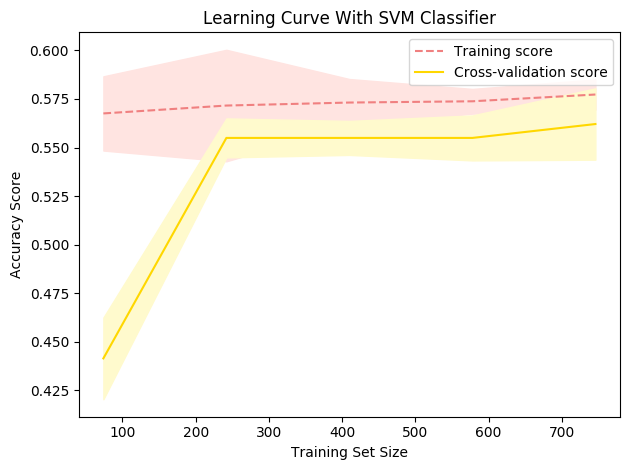

In [545]:
wine_svm.fit(wine_X_train, wine_Y_train)
wine_Y_pred = wine_svm.predict(wine_X_test)
wine_svm_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/o Tuning: ", wine_svm_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"C": [0.1, 1, 10, 30, 50, 75, 100], "gamma": [0.000001, 0.00001, 0.0001, 0.0000001]}
wine_svm_tuned = GridSearchCV(wine_svm, param_grid, scoring='accuracy', cv=3)
wine_svm_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_svm_tuned.best_params_
best_estimator = wine_svm_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_svm = best_estimator
final_wine_svm.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_svm.predict(wine_X_test)
final_wine_svm_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/ Tuning: ", final_wine_svm_accuracy)

create_learning_curve(final_wine_svm, wine_X_train, wine_Y_train, "SVM Classifier")

In [529]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"C": [0.1, 1, 10, 30, 50, 75, 100], "gamma": [0.000001, 0.00001, 0.0001, 0.0000001]}
wine_svm_tuned = GridSearchCV(wine_svm, param_grid, scoring='f1_macro', cv=3)
wine_svm_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_svm_tuned.best_params_
best_estimator = wine_svm_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_svm = best_estimator
final_wine_svm.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_svm.predict(wine_X_test)
final_wine_svm_f1_score = f1_score(wine_Y_test, wine_Y_pred, average="macro")
print("F1 Score w/ Tuning: ", final_wine_svm_f1_score)

Best Params:  {'C': 100, 'gamma': 0.0001} SVC(C=100, gamma=0.0001, random_state=5)
F1 Score w/ Tuning:  0.22373226111232788


In [385]:
fit_time_start = time.time()
final_wine_svm.fit(wine_X_train, wine_Y_train)
fit_time_end = time.time()
wine_fit_time = (fit_time_end - fit_time_start) * 100
wine_fit_times.append(wine_fit_time)

predict_time_start = time.time()
wine_Y_pred = final_wine_svm.predict(wine_X_test)
predict_time_end = time.time()
wine_predict_time = (predict_time_end - predict_time_start) * 100
wine_predict_times.append(wine_predict_time)

print(wine_fit_times, wine_predict_times)

final_wine_svm_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/ Tuning: ", final_wine_svm_accuracy)

[2.1558046340942383, 2.5634050369262695, 13.672614097595215] [0.32079219818115234, 5.999183654785156, 5.285096168518066]
Accuracy w/ Tuning:  0.60625


### Boosting

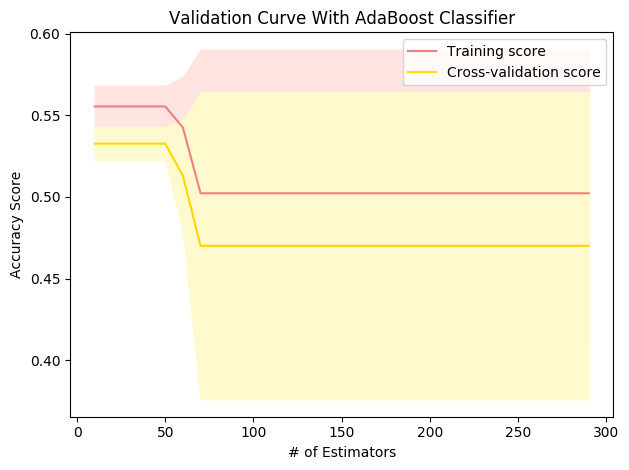

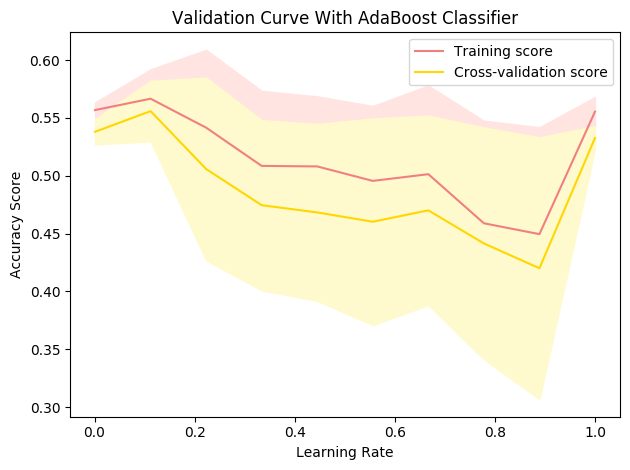

In [290]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
wine_boosting_dt = DecisionTreeClassifier(max_depth=1, random_state=5)
wine_boosting = AdaBoostClassifier(wine_boosting_dt, random_state=5)

create_validation_curve(wine_boosting, wine_X_train, wine_Y_train, "n_estimators", np.arange(10, 300, 10), "AdaBoost Classifier", "# of Estimators")
create_validation_curve(wine_boosting, wine_X_train, wine_Y_train, "learning_rate", np.linspace(0.001, 1.0, 10), "AdaBoost Classifier", "Learning Rate")

Accuracy w/o Tuning:  0.35625
Best Params:  {'base_estimator__max_depth': 6, 'learning_rate': 0.001, 'n_estimators': 55} AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                         random_state=5),
                   learning_rate=0.001, n_estimators=55, random_state=5)
Accuracy w/ Tuning:  0.6229166666666667


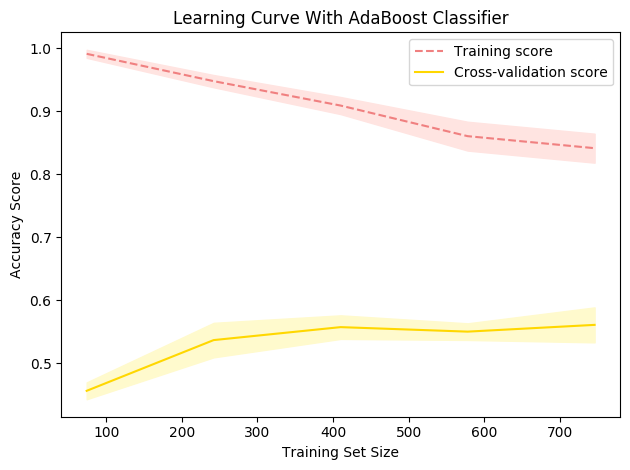

In [537]:
wine_boosting.fit(wine_X_train, wine_Y_train)
wine_Y_pred = wine_boosting.predict(wine_X_test)
wine_boosting_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/o Tuning: ", wine_boosting_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"n_estimators": [45, 50, 55, 60], "learning_rate": [0.001], 'base_estimator__max_depth':[6]}
wine_boosting_tuned = GridSearchCV(wine_boosting, param_grid, scoring='accuracy', cv=3)
wine_boosting_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_boosting_tuned.best_params_
best_estimator = wine_boosting_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_boosting = best_estimator
final_wine_boosting.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_boosting.predict(wine_X_test)
final_wine_boosting_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/ Tuning: ", final_wine_boosting_accuracy)

create_learning_curve(final_wine_boosting, wine_X_train, wine_Y_train, "AdaBoost Classifier")

In [538]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"n_estimators": [45, 50, 55, 60], "learning_rate": [0.001, 0.0001, 0.01], 'base_estimator__max_depth':[6]}
wine_boosting_tuned = GridSearchCV(wine_boosting, param_grid, scoring='f1_macro', cv=3)
wine_boosting_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_boosting_tuned.best_params_
best_estimator = wine_boosting_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_boosting = best_estimator
final_wine_boosting.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_boosting.predict(wine_X_test)
final_wine_boosting_f1_score = f1_score(wine_Y_test, wine_Y_pred, average="macro")
print("F1 Score w/ Tuning: ", final_wine_boosting_f1_score)

Best Params:  {'base_estimator__max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 55} AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                         random_state=5),
                   learning_rate=0.01, n_estimators=55, random_state=5)
F1 Score w/ Tuning:  0.34850280253949717


In [386]:
fit_time_start = time.time()
final_wine_boosting.fit(wine_X_train, wine_Y_train)
fit_time_end = time.time()
wine_fit_time = (fit_time_end - fit_time_start) * 100
wine_fit_times.append(wine_fit_time)

predict_time_start = time.time()
wine_Y_pred = final_wine_boosting.predict(wine_X_test)
predict_time_end = time.time()
wine_predict_time = (predict_time_end - predict_time_start) * 100
wine_predict_times.append(wine_predict_time)

print(wine_fit_times, wine_predict_times)

final_wine_boosting_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/ Tuning: ", final_wine_boosting_accuracy)

[2.1558046340942383, 2.5634050369262695, 13.672614097595215, 28.895902633666992] [0.32079219818115234, 5.999183654785156, 5.285096168518066, 1.1034727096557617]
Accuracy w/ Tuning:  0.6979166666666666


/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


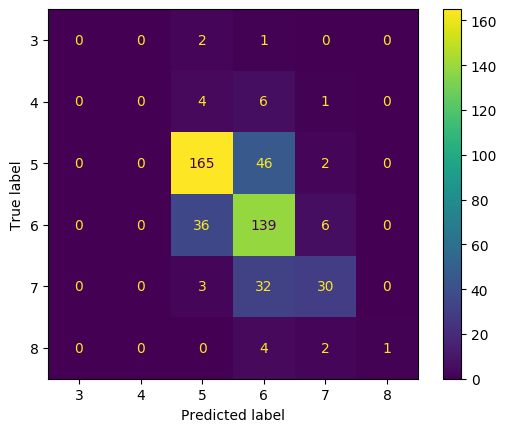

In [409]:
cm = plot_confusion_matrix(final_wine_boosting, wine_X_test, wine_Y_test)
plt.show()

### Neural Networks

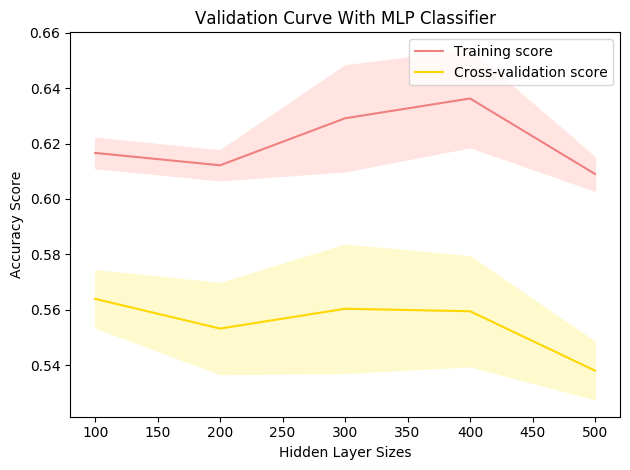

In [319]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
wine_mlp = MLPClassifier(random_state=5, max_iter=500, learning_rate_init=0.001, activation_layer='relu')

# create_validation_curve(wine_mlp, wine_X_train, wine_Y_train, "activation", ['identity', 'logistic', 'tanh', 'relu'], "MLP Classifier", "Activation")
create_validation_curve(wine_mlp, wine_X_train, wine_Y_train, "hidden_layer_sizes", [100, 200, 300, 400, 500], "MLP Classifier", "Hidden Layer Sizes")
# create_validation_curve(wine_mlp, wine_X_train, wine_Y_train, "learning_rate_init", [0.0001,0.001, 0.01, 0.1, 0.5, 1], "MLP Classifier", "Learning Rate Init")

Accuracy w/o Tuning:  0.6041666666666666
Best Params:  {'activation': 'relu', 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.001} MLPClassifier(hidden_layer_sizes=(400,), max_iter=500, random_state=5)
Accuracy w/ Tuning:  0.575


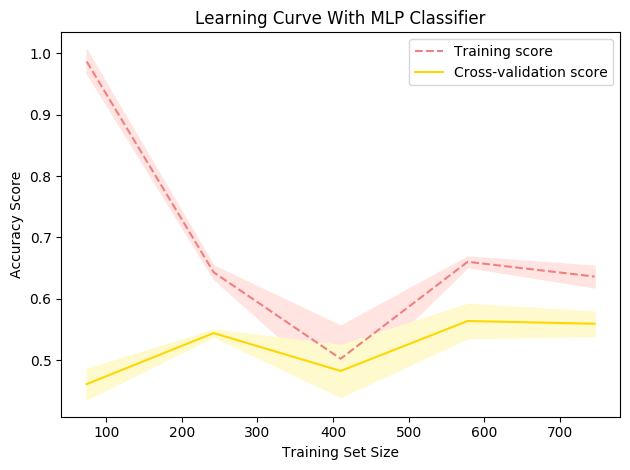

In [532]:
wine_mlp.fit(wine_X_train, wine_Y_train)
wine_Y_pred = wine_mlp.predict(wine_X_test)
wine_mlp_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/o Tuning: ", wine_mlp_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"hidden_layer_sizes": [(400,)], "learning_rate_init": [0.001], "activation": ['relu'],}
wine_mlp_tuned = GridSearchCV(wine_mlp, param_grid, scoring='accuracy', cv=3)
wine_mlp_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_mlp_tuned.best_params_
best_estimator = wine_mlp_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_mlp = best_estimator
final_wine_mlp.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_mlp.predict(wine_X_test)
final_wine_mlp_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/ Tuning: ", final_wine_mlp_accuracy)

create_learning_curve(final_wine_mlp, wine_X_train, wine_Y_train, "MLP Classifier")

In [535]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"hidden_layer_sizes": [300, 400,], "learning_rate_init": [0.0001, 0.001, 0.01], "activation": ['relu'],}
wine_mlp_tuned = GridSearchCV(wine_mlp, param_grid, scoring='f1_macro', cv=3)
wine_mlp_tuned.fit(wine_X_train, wine_Y_train)
best_params = wine_mlp_tuned.best_params_
best_estimator = wine_mlp_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_wine_mlp = best_estimator
final_wine_mlp.fit(wine_X_train, wine_Y_train)
wine_Y_pred = final_wine_mlp.predict(wine_X_test)
final_wine_mlp_f1_score = f1_score(wine_Y_test, wine_Y_pred, average="macro")
print("F1 Score w/ Tuning: ", final_wine_mlp_f1_score)

/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) r

Best Params:  {'activation': 'relu', 'hidden_layer_sizes': 400, 'learning_rate_init': 0.001} MLPClassifier(hidden_layer_sizes=400, max_iter=500, random_state=5)
F1 Score w/ Tuning:  0.25176635352944127


In [387]:
fit_time_start = time.time()
final_wine_mlp.fit(wine_X_train, wine_Y_train)
fit_time_end = time.time()
wine_fit_time = (fit_time_end - fit_time_start) * 100
wine_fit_times.append(wine_fit_time)

predict_time_start = time.time()
wine_Y_pred = final_wine_mlp.predict(wine_X_test)
predict_time_end = time.time()
wine_predict_time = (predict_time_end - predict_time_start) * 100
wine_predict_times.append(wine_predict_time)

print(wine_fit_times, wine_predict_times)

final_wine_mlp_accuracy = accuracy_score(wine_Y_test, wine_Y_pred)
print("Accuracy w/ Tuning: ", final_wine_mlp_accuracy)

[2.1558046340942383, 2.5634050369262695, 13.672614097595215, 28.895902633666992, 139.22901153564453] [0.32079219818115234, 5.999183654785156, 5.285096168518066, 1.1034727096557617, 0.35452842712402344]
Accuracy w/ Tuning:  0.575


/Users/aashiamehta/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training Score 0.0001 0.5638963360142984
Training Score 0.001 0.6023235031277927
Training Score 0.01 0.5817694369973191
Training Score 0.02 0.5996425379803396


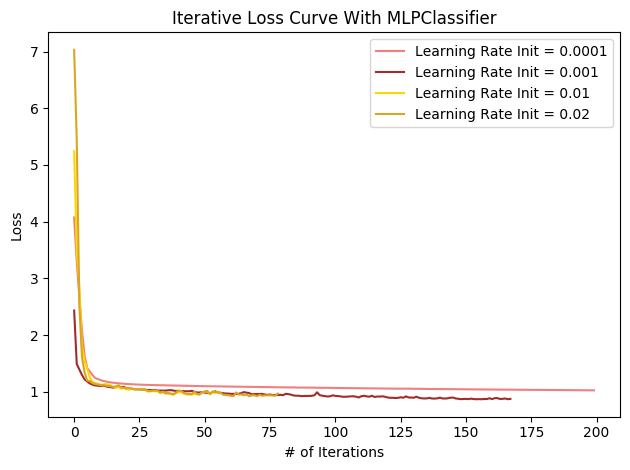

In [434]:
# https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html?highlight=loss+curve
wine_mlp_1 = MLPClassifier(hidden_layer_sizes=400, learning_rate_init = 0.0001, 
                           random_state=5)
wine_mlp_1.fit(wine_X_train, wine_Y_train)
plt.plot(wine_mlp_1.loss_curve_, color="lightcoral", label="Learning Rate Init = 0.0001")
print("Training Score 0.0001", wine_mlp_1.score(wine_X_train, wine_Y_train))

wine_mlp_2 = MLPClassifier(hidden_layer_sizes=400, learning_rate_init = 0.001, 
                           random_state=5)
wine_mlp_2.fit(wine_X_train, wine_Y_train)
plt.plot(wine_mlp_2.loss_curve_, color="brown", label="Learning Rate Init = 0.001")
print("Training Score 0.001", wine_mlp_2.score(wine_X_train, wine_Y_train))

wine_mlp_3 = MLPClassifier(hidden_layer_sizes=400, learning_rate_init = 0.01, 
                           random_state=5)
wine_mlp_3.fit(wine_X_train, wine_Y_train)
plt.plot(wine_mlp_3.loss_curve_, color="gold", label="Learning Rate Init = 0.01")
print("Training Score 0.01", wine_mlp_3.score(wine_X_train, wine_Y_train))

wine_mlp_4 = MLPClassifier(hidden_layer_sizes=400, learning_rate_init = 0.02, 
                           random_state=5)
wine_mlp_4.fit(wine_X_train, wine_Y_train)
plt.plot(wine_mlp_4.loss_curve_, color="goldenrod", label="Learning Rate Init = 0.02")
print("Training Score 0.02", wine_mlp_4.score(wine_X_train, wine_Y_train))


plt.title("Iterative Loss Curve With MLPClassifier")
plt.xlabel("# of Iterations")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

[2.1558046340942383, 2.5634050369262695, 13.672614097595215, 28.895902633666992, 139.22901153564453]
[0.0216, 0.289, 0.1367, 0.0256, 1.3923]


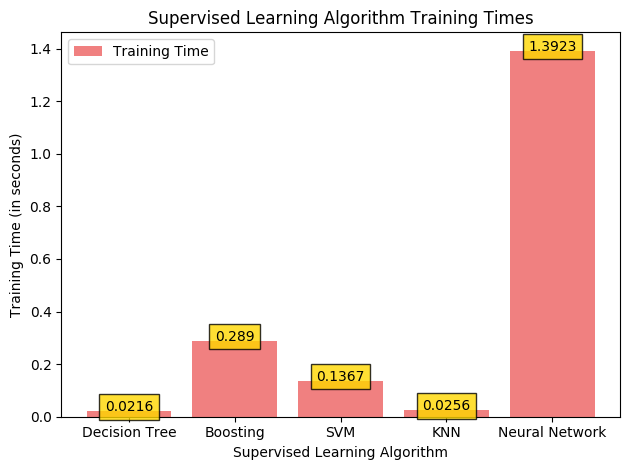

In [391]:
# https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html?highlight=loss+curve

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 Bbox = dict(facecolor = 'gold', alpha =.8))

classifiers = ["Decision Tree", "Boosting", "SVM", "KNN", "Neural Network"]
print(wine_fit_times)
wine_fit_times_s = [round(i / 100, 4) for i in wine_fit_times]
wine_fit_times_s = [0.0216, 0.289, 0.1367, 0.0256, 1.3923]
print(wine_fit_times_s)
plt.bar(classifiers, wine_fit_times_s, color="lightcoral", label="Training Time")
addlabels(classifiers, wine_fit_times_s)
plt.title("Supervised Learning Algorithm Training Times")
plt.xlabel("Supervised Learning Algorithm")
plt.ylabel("Training Time (in seconds)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

[0.32079219818115234, 5.999183654785156, 5.285096168518066, 1.1034727096557617, 0.35452842712402344]


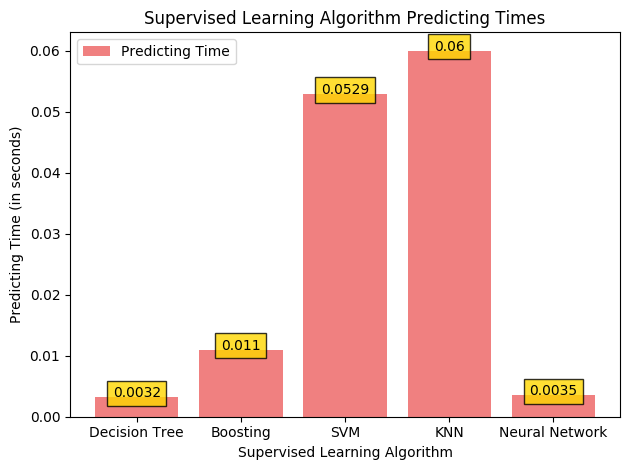

In [393]:
print(wine_predict_times)
wine_predict_times_s = [round(i / 100, 4) for i in wine_predict_times]
wine_predict_times_s = [0.0032,  0.011, 0.0529, 0.06, 0.0035]
plt.bar(classifiers, wine_predict_times_s, color="lightcoral", label="Predicting Time")
addlabels(classifiers, wine_predict_times_s)
plt.title("Supervised Learning Algorithm Predicting Times")
plt.xlabel("Supervised Learning Algorithm")
plt.ylabel("Predicting Time (in seconds)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [453]:
print(phishing_fit_times_s)
print(wine_fit_times_s)

print(sum(phishing_fit_times_s))
print(sum(wine_fit_times_s))
print(48.0513 - 1.8652000000000002)

print(phishing_predict_times_s)
print(wine_predict_times_s)
print(sum(phishing_predict_times_s))
print(sum(wine_predict_times_s))
print(1.7947 - 0.1306)

print(phishing_X_test.shape)
print(wine_X_test.shape)

[0.0213, 2.9666, 0.9312, 0.0057, 44.1265]
[0.0216, 0.289, 0.1367, 0.0256, 1.3923]
48.0513
1.8652000000000002
46.186099999999996
[0.0024, 0.14, 0.5478, 1.0466, 0.0579]
[0.0032, 0.011, 0.0529, 0.06, 0.0035]
1.7947
0.1306
1.6641
(3317, 30)
(480, 11)
3316.8
1094610
227040
